<a href="https://colab.research.google.com/github/AleksCipri/Concrete-Dropout---Mergers/blob/master/Concrete_Dropout_on_Mergers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip show keras

Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-applications, h5py, six, numpy, scipy, keras-preprocessing, pyyaml
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


In [0]:
!pip uninstall keras

Uninstalling Keras-2.2.5:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.5


In [0]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 4.6MB/s 


Based on https://github.com/yaringal/ConcreteDropout/blob/master/spatial-concrete-dropout-keras.ipynb

In [0]:
import sys
import numpy as np
np.random.seed(5)
import os
import codecs
import json
from numpy import random
from matplotlib import pyplot as plt

from keras.utils import to_categorical
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Wrapper

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
import json

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss

Using TensorFlow backend.


In [0]:
class SpatialConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given Conv2D input layer.
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """
    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, data_format=None, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(SpatialConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)
        self.data_format = 'channels_last' if data_format is None else 'channels_first'

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(SpatialConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 4, 'this wrapper only supports Conv2D layers'
        if self.data_format == 'channels_first':
            input_dim = input_shape[1] # we drop only channels
        else:
            input_dim = input_shape[3]
        
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def spatial_concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 2. / 3.

        input_shape = K.shape(x)
        if self.data_format == 'channels_first':
            noise_shape = (input_shape[0], input_shape[1], 1, 1)
        else:
            noise_shape = (input_shape[0], 1, 1, input_shape[3])
        unif_noise = K.random_uniform(shape=noise_shape)
        
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.spatial_concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.spatial_concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

In [0]:
class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        input_dim = np.prod(input_shape[-1])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

# Mnist

In [0]:
batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 7s 1us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
y_train.shape

(60000, 10)

In [0]:
N = len(x_train)
wd = 1e-2 / N
dd = 2. / N
model = Sequential()
model.add(SpatialConcreteDropout(Conv2D(32, kernel_size=(3, 3),
                                        activation='relu'),
                                 weight_regularizer=wd, dropout_regularizer=dd,
                                 input_shape=input_shape))
model.add(SpatialConcreteDropout(Conv2D(64, (3, 3), activation='relu'),
                                 weight_regularizer=wd, dropout_regularizer=dd))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(ConcreteDropout(Dense(128, activation='relu'), 
                          weight_regularizer=wd, dropout_regularizer=dd))
model.add(ConcreteDropout(Dense(num_classes, activation='softmax'), 
                          weight_regularizer=wd, dropout_regularizer=dd))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/5





60000/60000 [==============================] - 12s 208us/step - loss: 0.1203 - acc: 0.9316 - val_loss: -0.0552 - val_acc: 0.9667
Epoch 2/5
60000/60000 [==============================] - 5s 84us/step - loss: -0.1168 - acc: 0.9796 - val_loss: -0.1499 - val_acc: 0.9833
Epoch 3/5
60000/60000 [==============================] - 5s 84us/step - loss: -0.1623 - acc: 0.9858 - val_loss: -0.1651 - val_acc: 0.9856
Epoch 4/5
60000/60000 [==============================] - 5s 84us/step - loss: -0.1750 - acc: 0.9890 - val_loss: -0.1738 - val_acc: 0.9891
Epoch 5/5
60000/60000 [==============================] - 5s 82us/step - loss: -0.1831 - acc: 0.9910 - val_loss: -0.1734 - val_acc: 0.9873
Test loss: -0.17395257971286773
Test accuracy: 0.9874


In [0]:
ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
print(ps)

[0.01231672 0.03805816 0.47232345 0.05121954]


# Mergers

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ------------------------------------------------------------------------------
# Input variables
# ------------------------------------------------------------------------------

# training variables
# 70:10:20 for training:valid:test
nb_train = 10799
nb_valid = 1542
nb_test = 3085
nb_epoch = 200
nb_classes = 2
batch_size = 128
shuffle = True

# data locations
# pristine images
# for noisy images change SB00 to SB25 in all files that contain this part in their name
file_x_data = "/content/drive/My Drive/DeepMergeFiles/SB00_augmented.npy" # x data (images)
file_y_data = "/content/drive/My Drive/DeepMergeFiles/SB00_augmented_y.npy" # y data (labels) 

In [0]:
# load data, all filters
x_data = np.load(file_x_data)
y_data = np.load(file_y_data)

In [0]:
# ------------------------------------------------------------------------------
# Read in Data
# ------------------------------------------------------------------------------

#every day we shufflin
random.seed(5)
idx = np.random.choice(len(x_data), size=len(x_data), replace=False)
x_data = x_data[idx]
y_data = y_data[idx]



# check data sizes
statement =  "#TrainingSamples + #ValidSamples #TestSamples > TotalSamples, exiting!!!"
nb_total = nb_train + nb_test + nb_valid
assert nb_total <= len(x_data), statement

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[:ind_train_end, :, :, :]
x_valid = x_data[ind_valid_start: ind_valid_end, :, :, :]
x_test = x_data[ind_test_start: ind_test_end, :, :, :]

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

# cast data types
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')


print( "Data dimensions: ")
print( "Input data: ", np.shape(x_data), np.shape(y_data))
print( "Training set: ", np.shape(x_train), np.shape(y_train))
print( "Validation set: ", np.shape(x_valid), np.shape(y_valid))
print( "Test Set: ", np.shape(x_test), np.shape(y_test))

Data dimensions: 
Input data:  (15426, 2, 75, 75) (15426,)
Training set:  (10799, 2, 75, 75) (10799,)
Validation set:  (1542, 2, 75, 75) (1542,)
Test Set:  (3085, 2, 75, 75) (3085,)


In [0]:
print(y_train[:10])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

print(y_train[:10]) #[nonmerger,merger])

[0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [0]:
batch_size = 128
num_classes = 2
epochs = 200

# input image dimensions
img_rows, img_cols = 75, 75

K.set_image_data_format('channels_first')

if K.image_data_format() == 'channels_first':
#    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (2, img_rows, img_cols)
else:
#    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 2)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

N = len(x_train)
wd = 1e-3 / N #try other prior length scales, originaly in the code fro MNIST 1e-2
dd = 1. / N #not sure if i should use 1/N or 2/N for cross entropy loss
#originaly in the code it was 2/N but in the paper they say we should put 1
model = Sequential()
model.add(SpatialConcreteDropout(Conv2D(8, kernel_size=(5, 5),
                                        activation='relu'),
                                 weight_regularizer=wd, dropout_regularizer=dd,
                                 input_shape=input_shape))
                                
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(SpatialConcreteDropout(Conv2D(16, kernel_size=(3, 3),
                                        activation='relu'),
                                 weight_regularizer=wd, dropout_regularizer=dd))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(SpatialConcreteDropout(Conv2D(32, kernel_size=(3, 3),
                                        activation='relu'),
                                 weight_regularizer=wd, dropout_regularizer=dd))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(ConcreteDropout(Dense(64, activation='softmax'), 
                          weight_regularizer=wd, dropout_regularizer=dd))
model.add(ConcreteDropout(Dense(32, activation='softmax'), 
                          weight_regularizer=wd, dropout_regularizer=dd))
model.add(ConcreteDropout(Dense(num_classes, activation='softmax'), 
                          weight_regularizer=wd, dropout_regularizer=dd))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

x_train shape: (10799, 2, 75, 75)
10799 train samples
3085 test samples














_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_concrete_dropout_1 ( (None, 8, 71, 71)         409       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 71, 71)         284       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 35, 35)         0         
_________________________________________________________________
spatial_concrete_dropout_2 ( (None, 16, 33, 33)        1169      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 33, 33)        132       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
________________________________________________________

In [0]:
# data locations
dir_test = "/content/drive/My Drive/Colab Notebooks/model/"
f_model = dir_test + "SB00_model.json" # model data (architecture)
f_history = dir_test + "SB00_history.json" # training history 
f_weights = dir_test + "SB00_weights.h5" # model data (final weights)
f_best_weights = dir_test + "SB00_best_weights.h5" # model data (best weights, give highest validation accuracy)

In [0]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),
     ModelCheckpoint(f_best_weights, monitor='val_acc', mode='max', verbose=1, save_best_only=True)]

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=es)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

#Saving history for future use
with open(f_history, 'w') as f:
    json.dump(history.history, f)

Train on 10799 samples, validate on 1542 samples
Epoch 1/200
10799/10799 [==============================] - 4s 325us/step - loss: 0.6362 - acc: 0.5163 - val_loss: 0.6316 - val_acc: 0.5279

Epoch 00001: val_acc improved from -inf to 0.52789, saving model to /content/drive/My Drive/Colab Notebooks/model/SB00_best_weights.h5
Epoch 2/200
10799/10799 [==============================] - 2s 140us/step - loss: 0.6268 - acc: 0.5573 - val_loss: 0.6216 - val_acc: 0.5674

Epoch 00002: val_acc improved from 0.52789 to 0.56744, saving model to /content/drive/My Drive/Colab Notebooks/model/SB00_best_weights.h5
Epoch 3/200
10799/10799 [==============================] - 2s 144us/step - loss: 0.6141 - acc: 0.6216 - val_loss: 0.6046 - val_acc: 0.6608

Epoch 00003: val_acc improved from 0.56744 to 0.66083, saving model to /content/drive/My Drive/Colab Notebooks/model/SB00_best_weights.h5
Epoch 4/200
10799/10799 [==============================] - 2s 144us/step - loss: 0.5975 - acc: 0.6570 - val_loss: 0.5980

In [0]:
# dropout rates for each layer
ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
print('Dropout rates for each layer: ', ps)

[0.03214593 0.02833138 0.02614225 0.37809587 0.01916685 0.04315095]


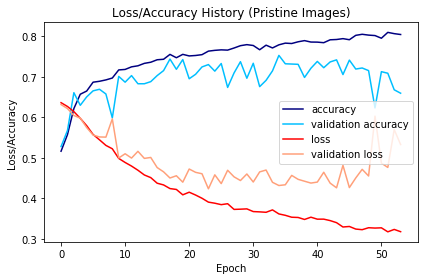

In [0]:
#plotting from history
hist = history.history
#LOSS
loss=hist['loss']
val_loss=hist['val_loss']
acc=hist['acc']
val_acc=hist['val_acc']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='center right')

In [0]:
prob = model.predict(x_test)

In [0]:
prob[:10]

array([[0.96052736, 0.0394727 ],
       [0.9691901 , 0.03080985],
       [0.9768276 , 0.0231724 ],
       [0.00710361, 0.9928964 ],
       [0.9823973 , 0.01760272],
       [0.00710031, 0.99289966],
       [0.95086265, 0.04913735],
       [0.06043981, 0.93956023],
       [0.9816081 , 0.01839186],
       [0.9760125 , 0.02398754]], dtype=float32)

In [0]:
pred =  (prob > 0.5).astype('int32') 
pred[:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0]], dtype=int32)

In [0]:
y_test[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

cm [[1246.  179.]
 [ 929.  731.]]
cm_norm [[0.87438596 0.12561404]
 [0.55963855 0.44036145]]
AUC: 0.7329536038892412


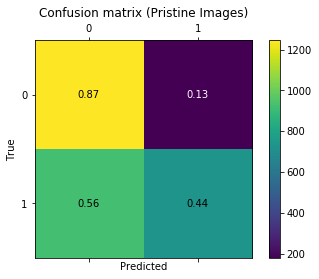

In [0]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET
# ------------------------------------------------------------------------------

# predict
prob = model.predict(x_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0,1]
cm = metrics.confusion_matrix(y_test[:,1], pred[:,1], labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

fpr, tpr, thresholds = metrics.roc_curve(y_test[:,1], prob[:,1], pos_label=1)
auc = metrics.roc_auc_score(y_test, prob)
print("AUC:", auc)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix (Pristine Images)', y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
plt.show()

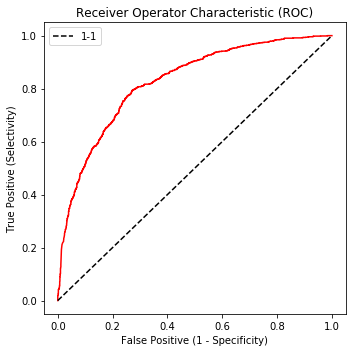

In [0]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test[:,1], pred[:,1])
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test[:,1], pred[:,1])
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test[:,1], pred[:,1])
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[:,1], pred[:,1])
print('F1 score: %f' % f1)

# brier score
bs = brier_score_loss(y_test[:,1], prob[:,1])
print('Brier score: %f' % bs)

Accuracy: 0.700486
Precision: 0.656064
Recall: 0.931928
F1 score: 0.770035
Brier score: 0.257284
